This notebook is part of *The 2019 Australian Open Radar Science Course*.

Copyright (c) Kai Muehlbauer.

Distributed under the BSD 2-Clause "Simplified" License. See LICENSE for more info.

# A Taste of wradlib

As you already know, $\omega radlib$ is a rather low level library. In this notebook some of the features are shown, which should give you an first impression on how to use $\omega radlib$. 

For a more in-depth look into the capabilities of wradlib, please use the notebooks provided in the [VM](https://openradarscience.org/vm-docs/). You also might just start at [wradlib.org](https://wradlib.org/).

## Import needed python packages

In [1]:
import wradlib as wrl
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as pl
import numpy as np
import xarray as xr
import glob
import os
from tqdm import tqdm_notebook as tqdm
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()

## Get hold of some  some Australien Radar Data

The `filepath` and the `filename` below have to be set to the correct folder and the correct naming scheme. It is assumed, that data from IDR71 (Sidney) from 20th of December 2018 is used in this notebook.

In [60]:
filepath = os.path.expanduser('/home/kai/daten/daten/radar_all_over_the_world/71_20181220.pvol')
filename = '71_*.pvol.h5'
idr71 = glob.glob(os.path.join(filepath, filename))
idr71.sort()
print("Files available: {}".format(len(idr71)))

Files available: 240


## Open ODIM_H5 Volume


In [61]:
odh = wrl.io.open_odim_dataset(idr71[72])

In [62]:
display(odh)

<wradlib.RadarVolume>
Dimension(s): (sweep: 14)
Elevation(s): (0.5, 0.9, 1.3, 1.8, 2.4, 3.1, 4.2, 5.6, 7.4, 10.0, 13.3, 17.9, 23.9, 32.0)

## Quasi Vertical Profile (QVP)

This example shows how to create a so called QVP. We need to define a function to add a height coordinate for plotting.

In [20]:
def add_height(ds):
    ds = ds.pipe(wrl.georef.georeference_dataset)
    height = ds.z.mean('azimuth')
    ds = ds.assign_coords({'height': (['range'], height.data)})
    return ds

### Single Profile

Here we add the height coordinate and calculate the `mean` over the azimuth using the sweep with the highest available elevation.

In [21]:
swp14 = odh[13].pipe(add_height)
qvp = swp14.mean('azimuth')
qvp

<xarray.Dataset>
Dimensions:     (range: 200)
Coordinates:
  * range       (range) float32 125.0 375.0 625.0 ... 4.962e+04 4.988e+04
    time        datetime64[ns] 2018-12-20T07:16:35
    sweep_mode  <U20 'azimuth_surveillance'
    longitude   float64 151.2
    latitude    float64 -33.7
    altitude    float64 195.0
    height      (range) float32 262.0 395.0 527.0 ... 2.66e+04 2.673e+04
Data variables:
    DBZH        (range) float32 -0.5714 -3.465 -3.004 -5.493 ... nan nan nan nan
    DBZH_CLEAN  (range) float32 nan nan nan nan nan ... -31.9 -31.9 -31.9 -31.9
    VRADDH      (range) float32 -299.9 nan nan nan ... -299.9 -299.9 -299.9
    VRADH       (range) float32 -2.709 0.1238 0.8131 0.1725 ... nan nan nan nan
    WRADH       (range) float32 7.304 3.395 3.145 3.064 ... nan nan nan nan
    TH          (range) float32 15.41 0.8208 2.189 0.2972 ... nan nan nan nan
    ZDR         (range) float32 -2.783 1.318 1.912 1.127 ... nan nan nan nan
    RHOHV       (range) float32 0.2315 0.6305 0.6309 0.5778 ... nan nan nan nan
    PHIDP       (range) float32 178.6 100.6 107.9 115.6 ... nan nan nan nan
    KDP         (range) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    SNRH        (range) float32 55.92 44.39 40.41 34.99 ... 0.6139 0.5743 0.6364

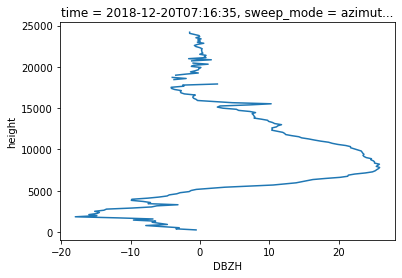

In [26]:
qvp.DBZH.plot(y='height')

### TimeSeries QVP

The following is preliminary code which is currently implemented in wradlib and will be available in the next version. There are some glitches which have to be fixed, yet, see below.

This loads multiple volumes and combines the sweeps (here only one sweep) along a new time dimension.

In [23]:
len(idr71)
def drop_moments(swp):
    swp = swp.drop_vars(["DBZH_CLEAN", "VRADDH", "KDP"], errors="ignore")
    return swp

In [ ]:
wrl.io.open_odim_dataset()

In [46]:
ts = xr.open_mfdataset(idr71[4*12:8*12], engine="odim", group="dataset14", preprocess=drop_moments, combine="nested", concat_dim="time")

In [47]:
ts["longitude"] = ts.longitude.median()
ts["latitude"] = ts.latitude.median()

In [ ]:
ts = {}
ts['fh'] = []
ts['swp'] = []
for f in tqdm(idr71, desc='Collecting', unit=' Files'):
    fh = wrl.io.OdimH5(f, dim0='azimuth', chunks={})
    ts['fh'].append(fh)
    ds = fh['sweep_14']
    # reassign time 
    ds = ds.rename({'time': 'rtime'})
    ds = ds.assign_coords({'time': (['time'], [ds['rtime'].min().values])})
    ts['swp'].append(ds)

#### Georeference and add height coordinate

In [48]:
ts = ts.pipe(add_height)
display(ts)

<xarray.Dataset>
Dimensions:     (time: 48, azimuth: 360, range: 200)
Coordinates: (12/16)
  * azimuth     (azimuth) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    elevation   (azimuth) float32 dask.array<chunksize=(360,), meta=np.ndarray>
    rtime       (time, azimuth) datetime64[ns] dask.array<chunksize=(1, 360), meta=np.ndarray>
  * range       (range) float32 125.0 375.0 625.0 ... 4.962e+04 4.988e+04
  * time        (time) datetime64[ns] 2018-12-20T04:52:32 ... 2018-12-20T09:3...
    sweep_mode  <U20 'azimuth_surveillance'
    ...          ...
    y           (azimuth, range) float32 106.0 318.0 ... 4.195e+04 4.216e+04
    z           (azimuth, range) float32 262.0 395.0 ... 2.66e+04 2.673e+04
    gr          (azimuth, range) float32 106.0 318.0 ... 4.195e+04 4.216e+04
    rays        (azimuth, range) float32 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5
    bins        (azimuth, range) float32 125.0 375.0 ... 4.962e+04 4.988e+04
    height      (range) float32 262.0 395.0 527.0 ... 2.66e+04 2.673e+04
Data variables:
    DBZH        (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    VRADH       (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    WRADH       (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    TH          (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    ZDR         (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    RHOHV       (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    PHIDP       (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
    SNRH        (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 200), meta=np.ndarray>
Attributes:
    fixed_angle:  32.0

#### Calculate QVP

In [58]:
ts_qvp = ts.median('azimuth', skipna=True)
ts_qvp

<xarray.Dataset>
Dimensions:     (time: 48, range: 200)
Coordinates:
  * range       (range) float32 125.0 375.0 625.0 ... 4.962e+04 4.988e+04
  * time        (time) datetime64[ns] 2018-12-20T04:52:32 ... 2018-12-20T09:3...
    sweep_mode  <U20 'azimuth_surveillance'
    longitude   float64 151.2
    latitude    float64 -33.7
    altitude    float64 195.0
    height      (range) float32 262.0 395.0 527.0 ... 2.66e+04 2.673e+04
Data variables:
    DBZH        (time, range) float32 dask.array<chunksize=(1, 200), meta=np.ndarray>
    VRADH       (time, range) float32 dask.array<chunksize=(1, 200), meta=np.ndarray>
    WRADH       (time, range) float32 dask.array<chunksize=(1, 200), meta=np.ndarray>
    TH          (time, range) float32 dask.array<chunksize=(1, 200), meta=np.ndarray>
    ZDR         (time, range) float32 dask.array<chunksize=(1, 200), meta=np.ndarray>
    RHOHV       (time, range) float32 dask.array<chunksize=(1, 200), meta=np.ndarray>
    PHIDP       (time, range) float32 dask.array<chunksize=(1, 200), meta=np.ndarray>
    SNRH        (time, range) float32 dask.array<chunksize=(1, 200), meta=np.ndarray>

#### Plot QVP using discrete colorbar

Text(0.5, 1.0, 'Quasi Vertical Profile')

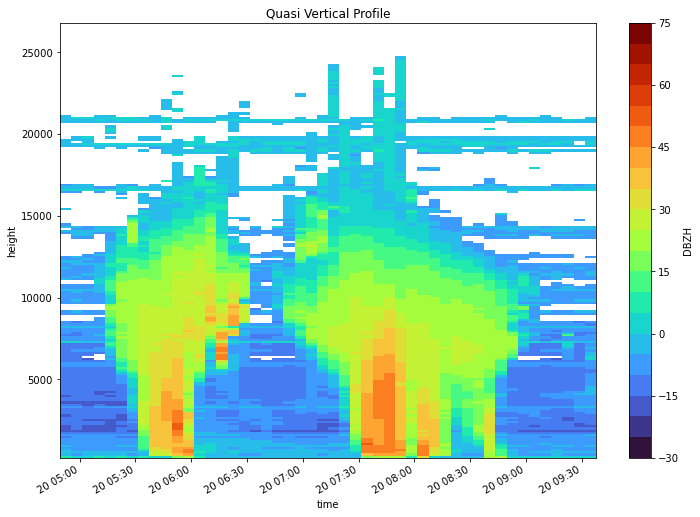

In [59]:
fig = pl.figure(figsize=(12,8))
levels = np.arange(-30, 80, 5)
ts_qvp.DBZH.plot(x='time', y='height', cmap='turbo', levels=levels)
pl.gca().set_title('Quasi Vertical Profile')

## Simple Clutter Filter

This extracts clutter information using a approach published by Gabella.

### Define function to be used with Xarray Dataset

In [31]:
def extract_clutter(ds):
    clmap = wrl.clutter.filter_gabella(ds.DBZH.values,
                                       wsize=5,
                                       thrsnorain=0.,
                                       tr1=6.,
                                       n_p=8,
                                       tr2=1.3, 
                                       rm_nans=False)
    ds = ds.assign({'CMAP': (ds.DBZH.dims, clmap)})
    return ds

### Pipe the function, which returns a Dataset with added `CMAP` 

In [32]:
swp1 = swp1.pipe(extract_clutter)
swp1

<xarray.Dataset>
Dimensions:     (azimuth: 360, range: 1200)
Coordinates: (12/15)
  * azimuth     (azimuth) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    elevation   (azimuth) float32 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5 0.5
    rtime       (azimuth) datetime64[ns] 2018-12-20T07:12:35.518047488 ... 20...
  * range       (range) float32 125.0 375.0 625.0 ... 2.996e+05 2.999e+05
    time        datetime64[ns] 2018-12-20T07:12:30
    sweep_mode  <U20 'azimuth_surveillance'
    ...          ...
    x           (azimuth, range) float32 1.091 3.272 ... -2.613e+03 -2.615e+03
    y           (azimuth, range) float32 125.0 375.0 ... 2.994e+05 2.996e+05
    z           (azimuth, range) float32 197.0 199.0 ... 8.09e+03 8.101e+03
    gr          (azimuth, range) float32 125.0 375.0 ... 2.994e+05 2.996e+05
    rays        (azimuth, range) float32 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5
    bins        (azimuth, range) float32 125.0 375.0 ... 2.996e+05 2.999e+05
Data variables:
    DBZH        (azimuth, range) float32 nan nan -13.0 nan ... nan nan nan nan
    DBZH_CLEAN  (azimuth, range) float32 ...
    VRADDH      (azimuth, range) float32 ...
    VRADH       (azimuth, range) float32 ...
    WRADH       (azimuth, range) float32 ...
    TH          (azimuth, range) float32 ...
    ZDR         (azimuth, range) float32 ...
    RHOHV       (azimuth, range) float32 ...
    PHIDP       (azimuth, range) float32 ...
    KDP         (azimuth, range) float32 ...
    SNRH        (azimuth, range) float32 ...
    CMAP        (azimuth, range) bool False False False ... False False False
Attributes:
    fixed_angle:  0.5

In [33]:
swp1.DBZH_CLEAN.min(skipna=True)

<xarray.DataArray 'DBZH_CLEAN' ()>
array(-31.9, dtype=float32)
Coordinates:
    time        datetime64[ns] 2018-12-20T07:12:30
    sweep_mode  <U20 'azimuth_surveillance'
    longitude   float64 151.2
    latitude    float64 -33.7
    altitude    float64 195.0

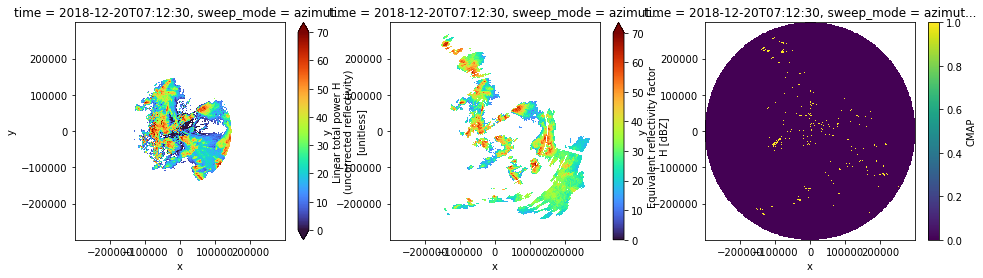

In [34]:
fig = pl.figure(figsize=(16,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
swp1.TH.plot(x="x", y="y", ax=ax1, cmap="turbo", vmin=0, vmax=70)
swp1.DBZH_CLEAN.where(swp1.DBZH_CLEAN > 10).plot(x="x", y="y", ax=ax2, cmap="turbo", vmin=0, vmax=70)
swp1.CMAP.plot(x="x", y="y", ax=ax3, cmap="viridis")


## Dual-Pol retrievals

This is just one example for using dual pol moments. Here we facilitate `RHOHV` and `ZDR` to calculate Depolarization Ratio.

### Depolarizaton Ratio

We create the function, to be used with the Xarray Dataset, pipe it and create the diagnostic plot.

In [35]:
def depol(ds):
    dep = wrl.dp.depolarization(ds.ZDR.values,
                                ds.RHOHV.values)
    ds = ds.assign({'DR': (ds.DBZH.dims, dep)})
    return ds

In [36]:
swp1 = swp1.pipe(depol)
swp1

<xarray.Dataset>
Dimensions:     (azimuth: 360, range: 1200)
Coordinates: (12/15)
  * azimuth     (azimuth) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    elevation   (azimuth) float32 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5 0.5
    rtime       (azimuth) datetime64[ns] 2018-12-20T07:12:35.518047488 ... 20...
  * range       (range) float32 125.0 375.0 625.0 ... 2.996e+05 2.999e+05
    time        datetime64[ns] 2018-12-20T07:12:30
    sweep_mode  <U20 'azimuth_surveillance'
    ...          ...
    x           (azimuth, range) float32 1.091 3.272 ... -2.613e+03 -2.615e+03
    y           (azimuth, range) float32 125.0 375.0 ... 2.994e+05 2.996e+05
    z           (azimuth, range) float32 197.0 199.0 ... 8.09e+03 8.101e+03
    gr          (azimuth, range) float32 125.0 375.0 ... 2.994e+05 2.996e+05
    rays        (azimuth, range) float32 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5
    bins        (azimuth, range) float32 125.0 375.0 ... 2.996e+05 2.999e+05
Data variables: (12/13)
    DBZH        (azimuth, range) float32 nan nan -13.0 nan ... nan nan nan nan
    DBZH_CLEAN  (azimuth, range) float32 nan nan nan nan ... -31.9 -31.9 -31.9
    VRADDH      (azimuth, range) float32 ...
    VRADH       (azimuth, range) float32 ...
    WRADH       (azimuth, range) float32 ...
    TH          (azimuth, range) float32 ...
    ...          ...
    RHOHV       (azimuth, range) float32 nan nan 0.5197 0.5315 ... nan nan nan
    PHIDP       (azimuth, range) float32 ...
    KDP         (azimuth, range) float32 ...
    SNRH        (azimuth, range) float32 ...
    CMAP        (azimuth, range) bool False False False ... False False False
    DR          (azimuth, range) float32 nan nan -3.63 -3.351 ... nan nan nan
Attributes:
    fixed_angle:  0.5

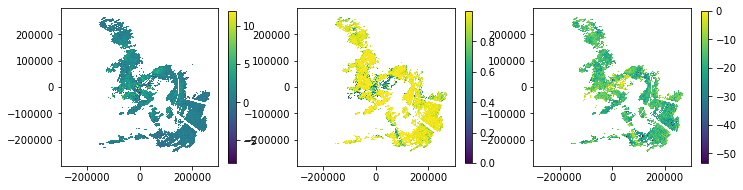

In [37]:
fig = pl.figure(figsize=(12,8))
qm = swp1.ZDR.wradlib.plot(ax=131, fig=fig)
pl.colorbar(qm, pad=0.05, shrink=0.35)
qm = swp1.RHOHV.wradlib.plot(ax=132, fig=fig)
pl.colorbar(qm, pad=0.05, shrink=0.35)
qm = swp1.DR.wradlib.plot(ax=133, fig=fig)
pl.colorbar(qm, pad=0.05, shrink=0.35)

## Create 3D-Volume

This is just one example of creating a 3D representation of the volume data.

### Iterate over the sweeps and extract coordinates and data

This takes the radar location and the given projection into account. Here: using UTM65S, for Sydney radar. Change accordingly for other radar locations.

In [38]:
from osgeo import osr
proj = osr.SpatialReference()
proj.ImportFromEPSG(32756)
xyz, data = np.array([]).reshape((-1, 3)), np.array([])
site
for swp in odh:
    xyz_ = wrl.vpr.volcoords_from_polar(site, swp.fixed_angle,
                                        swp.azimuth.values, swp.range.values, proj=proj)
    xyz, data = np.vstack((xyz, xyz_)), np.append(data, swp.TH.values.ravel())

### Initialize Volume Parameters

Try with the given set of parameters. If the processing time is small, then increase `maxalt` until you see the storm top. Increase horizontal and vertical resolution for more details.

In [39]:
import datetime as dt
# generate 3-D Cartesian target grid coordinates
maxrange = 200000.
minelev = 0.1
maxelev = 25.
maxalt = 5000.
horiz_res = 2000.
vert_res = 250.
trgxyz, trgshape = wrl.vpr.make_3d_grid(site, proj, maxrange,
                                        maxalt, horiz_res, vert_res)

# interpolate to Cartesian 3-D volume grid
tstart = dt.datetime.now()
gridder = wrl.vpr.CAPPI(xyz, trgxyz, trgshape, maxrange, minelev,
                        maxelev)
vol = np.ma.masked_invalid(gridder(data).reshape(trgshape))
print("3-D interpolation took:", dt.datetime.now() - tstart)

3-D interpolation took: 0:00:00.851594


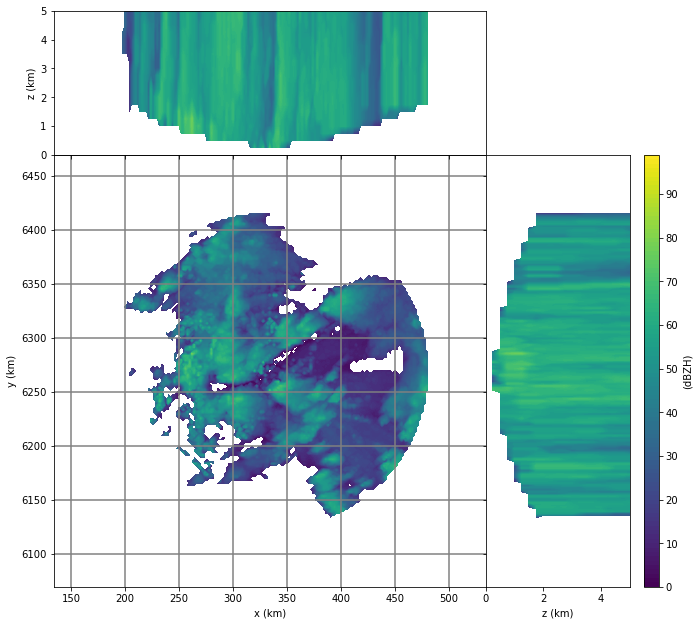

In [40]:
# diagnostic plot
trgx = trgxyz[:, 0].reshape(trgshape)[0, 0, :]
trgy = trgxyz[:, 1].reshape(trgshape)[0, :, 0]
trgz = trgxyz[:, 2].reshape(trgshape)[:, 0, 0]
wrl.vis.plot_max_plan_and_vert(trgx, trgy, trgz, vol, unit="dBZH",
                               levels=range(0, 100))

In [125]:
vol.shape

(21, 201, 201)